In [1]:
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from pyJoules.device.nvidia_device import NvidiaGPUDomain
from pyJoules.handler.pandas_handler import PandasHandler
from pyJoules.energy_meter import measure_energy

from Bio import SeqIO
import pandas as pd
import numpy as np
from time import perf_counter_ns
import matplotlib.pyplot as plt
import gc

SEQ_MAX_LEN = 5000
batch_size = 1

loss_fn = nn.CrossEntropyLoss()
pandas_handler = PandasHandler()

c:\Users\lgltan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CUDA/Torch GPU Setup

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4060 Ti


## Convert FASTA file to pd.DataFrame for easier processing

In [3]:
def fasta_to_dataframe(fasta_file):
    records = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        if len(records) >= 8000:
            break
        # Extract the ID after '>tr'
        id_info = seq_record.id.split('|')[1] # Adjust the index based on your FASTA file format
        sequence = str(seq_record.seq)
        if len(sequence) <= SEQ_MAX_LEN:
            # Generate a random index within the range of the sequence length
            random_index = np.random.randint(0, min(len(sequence), SEQ_MAX_LEN))
            # Replace the character at the random index with '<mask>'
            masked_sequence = sequence[:random_index] + '<mask>' + sequence[random_index+1:]
            
            records.append([id_info, sequence, masked_sequence])
    
    # Create a DataFrame from the records
    df = pd.DataFrame(records, columns=['ID', 'Sequence', 'Masked_Sequence'])
    return df

## Create Dataset

In [4]:
fasta_df = fasta_to_dataframe("human_protein_seq/uniprotkb_proteome_UP000005640.fasta")

In [5]:
fasta_df.head()

,ID,Sequence,Masked_Sequence
0,A0A075B6G3,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...
1,A0A087WV00,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...
2,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,MELSAEYL<mask>EKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...


In [6]:
fasta_df.shape

(8000, 3)

## Preparing your model and tokenizer

Now we load our model and tokenizer. If using GPU, use `model.cuda()` to transfer the model to GPU.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D")

In [8]:
class FastaDataset(Dataset):
    def __init__(self, fasta_df, tokenizer):
        self.fasta_df = fasta_df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.fasta_df)

    def __getitem__(self, idx):
        fasta_row = self.fasta_df.iloc[idx]
        latency_time_stamps = []
        # TIME LOG: start
        latency_time_stamps.append(perf_counter_ns())

        # Tokenize the input and move it to the correct device
        inputs = tokenizer(fasta_row["Masked_Sequence"], max_length=min(len(fasta_row["Masked_Sequence"]), SEQ_MAX_LEN), truncation=True, return_tensors='pt')
        
        # TIME LOG: tokenize
        latency_time_stamps.append(perf_counter_ns())
        
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # TIME LOG: move_to_gpu
        latency_time_stamps.append(perf_counter_ns())
        
        unmasked_text = fasta_row['Sequence']
        masked_text = fasta_row["Masked_Sequence"]
        mask_position = masked_text.find('<mask>')
        actual_token = unmasked_text[mask_position]
        
        with torch.no_grad():
            logits = model(**inputs).logits
        
        # TIME LOG: model
        latency_time_stamps.append(perf_counter_ns())

        # Convert the actual token to its corresponding ID
        actual_token_id = tokenizer.encode(actual_token, add_special_tokens=False)[0]

        # Prepare the target tensor
        target = torch.tensor([actual_token_id] + np.zeros(33, dtype=np.longlong), device=device).unsqueeze(0)
        
        # Calculate the cross-entropy loss
        loss = loss_fn(logits, target)
        
        # Convert the fasta_row to a dictionary before returning
        fasta_row_dict = fasta_row.to_dict()
        
        return loss, latency_time_stamps, fasta_row_dict


In [9]:
# Instantiate the dataset
fasta_dataset = FastaDataset(fasta_df, tokenizer)

# Create a DataLoader
dataloader = DataLoader(fasta_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Ensure the model is in evaluation mode
model.eval()

model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, 

# TODO: Make more memory efficient

In [11]:
print(f"Running test on {fasta_df.shape[0]} sequences.")

gc.disable()

# set up accuracy & latency info - leave this in the same code block so that it resets each time
accuracy = []
latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', "end"])
sequence_length = []
# memory_usage = []
ctr = 0
iter_dl = iter(dataloader)

@measure_energy(domains=[NvidiaGPUDomain(0)], handler=pandas_handler)
def run(accuracy, latency, iter_dl):
    loss, latency_time_stamps, fasta_row = next(iter_dl)

    fasta_df = pd.DataFrame.from_dict(fasta_row)

    # TIME LOG: end
    latency_time_stamps.append(perf_counter_ns())

    # Append the loss to a list or use it as needed
    accuracy.append(loss.item())
        
    # memory_usage.append(torch.cuda.memory_allocated())

    # unrolled loop
    latency_time_stamps[0] = int(latency_time_stamps[0])
    latency_time_stamps[1] = int(latency_time_stamps[1])
    latency_time_stamps[2] = int(latency_time_stamps[2])
    latency_time_stamps[3] = int(latency_time_stamps[3])
    
    # print(latency_time_stamps)
    latency.loc[len(latency.index)] = latency_time_stamps
    # print(fasta_df)
    
    return len(fasta_df["Sequence"][0])

torch.cuda.empty_cache()

# for ctr in range(5):
for ctr in range(fasta_df.shape[0]):
    if ctr % 100 == 0:
        percentage = "{:.2f}".format(ctr * 100 / fasta_df.shape[0])
        print(f"Processing... {percentage}%")

    torch.cuda.empty_cache()
    # try to save as much memory as possible by reducing fragmentation
    gc.collect()
    
    # load model to GPU
    model.to(device)

    sequence_length.append(run(accuracy, latency, iter_dl))
    
    # try to remove anything no longer needed on the GPU mem
    gc.collect()
            
gc.enable()
gpu_util_df = pandas_handler.get_dataframe()

Running test on 8000 sequences.
Processing... 0.00%
Processing... 1.25%
Processing... 2.50%
Processing... 3.75%
Processing... 5.00%
Processing... 6.25%
Processing... 7.50%
Processing... 8.75%
Processing... 10.00%
Processing... 11.25%
Processing... 12.50%
Processing... 13.75%
Processing... 15.00%
Processing... 16.25%
Processing... 17.50%
Processing... 18.75%
Processing... 20.00%
Processing... 21.25%
Processing... 22.50%
Processing... 23.75%
Processing... 25.00%
Processing... 26.25%
Processing... 27.50%
Processing... 28.75%
Processing... 30.00%
Processing... 31.25%
Processing... 32.50%
Processing... 33.75%
Processing... 35.00%
Processing... 36.25%
Processing... 37.50%
Processing... 38.75%
Processing... 40.00%
Processing... 41.25%
Processing... 42.50%
Processing... 43.75%
Processing... 45.00%
Processing... 46.25%
Processing... 47.50%
Processing... 48.75%
Processing... 50.00%
Processing... 51.25%
Processing... 52.50%
Processing... 53.75%
Processing... 55.00%
Processing... 56.25%
Processing

Due to memory constraints, sequences over 10k characters in length have been dropped from the dataset for this model; hence only 1 set of graphs are made

In [12]:
print(accuracy)

[13.019295692443848, 11.62570858001709, 6.857203483581543, 12.477795600891113, 12.149155616760254, 11.234204292297363, 12.461569786071777, 9.655603408813477, 11.970930099487305, 6.09857702255249, 11.765823364257812, 13.080986022949219, 13.257597923278809, 6.907784461975098, 12.550604820251465, 7.930530071258545, 13.786643028259277, 12.170893669128418, 12.313124656677246, 13.735777854919434, 14.457942962646484, 10.773578643798828, 12.497129440307617, 13.30467414855957, 13.786836624145508, 12.835562705993652, 13.155426979064941, 13.461640357971191, 13.818490028381348, 11.783872604370117, 13.265220642089844, 11.338412284851074, 12.840789794921875, 13.892789840698242, 13.533032417297363, 12.985209465026855, 13.862634658813477, 12.274116516113281, 10.023003578186035, 12.612346649169922, 11.312434196472168, 10.559404373168945, 11.303436279296875, 13.282580375671387, 11.03120231628418, 14.597393989562988, 9.791322708129883, 13.647926330566406, 8.891128540039062, 11.296989440917969, 13.7945709

In [13]:
print(sequence_length)

[3685, 1057, 44, 515, 551, 631, 807, 54, 783, 16, 201, 2509, 1607, 68, 788, 215, 695, 583, 615, 390, 569, 1569, 1089, 715, 843, 239, 213, 388, 416, 714, 593, 554, 514, 362, 867, 1052, 921, 886, 244, 1464, 581, 106, 631, 596, 475, 339, 232, 786, 181, 330, 782, 686, 279, 195, 1463, 632, 161, 88, 1219, 281, 1573, 749, 911, 289, 425, 527, 597, 438, 1435, 2371, 802, 115, 521, 373, 952, 948, 315, 354, 1609, 1905, 1761, 451, 298, 854, 387, 747, 235, 447, 266, 440, 175, 379, 3374, 1075, 446, 355, 595, 941, 300, 1024, 270, 456, 2376, 827, 1044, 2624, 402, 1476, 301, 250, 823, 673, 496, 321, 472, 376, 432, 517, 919, 504, 115, 1288, 149, 568, 446, 2005, 329, 193, 221, 299, 251, 430, 265, 407, 481, 231, 507, 2137, 339, 2263, 132, 815, 435, 438, 444, 850, 1837, 1983, 2087, 615, 611, 873, 1229, 465, 1454, 201, 914, 251, 1242, 405, 467, 144, 555, 81, 275, 354, 420, 251, 92, 494, 240, 326, 462, 1017, 431, 385, 290, 375, 1149, 198, 2615, 516, 222, 701, 1018, 85, 288, 854, 2548, 222, 78, 422, 506, 563, 

In [14]:
latency.head()

,start,tokenize,move_to_gpu,model,end
0,574605325294200,574605328289600,574605328438600,574606819393300,574607988469300
1,574608130553700,574608131525600,574608131682600,574608373787500,574608374424900
2,574608503371100,574608503719700,574608504027700,574608525810400,574608526842300
3,574608654651900,574608655206700,574608655398700,574608694034300,574608750406200
4,574608876114500,574608876684700,574608876844200,574608914998400,574608975214700


### Cross Entropy Loss x Sequence Length

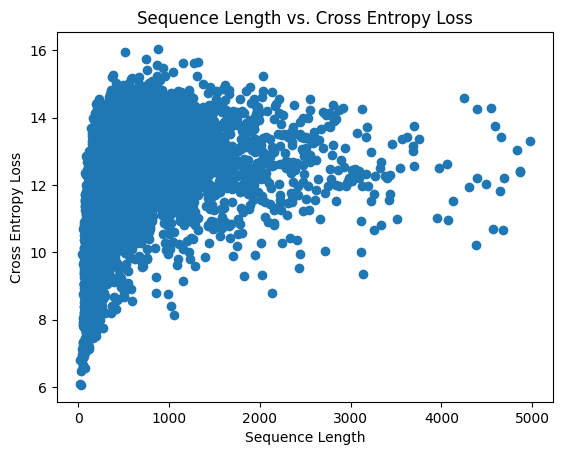

In [15]:
# Create a scatter plot
plt.scatter(sequence_length, accuracy)

# Label the axes
plt.xlabel('Sequence Length')
plt.ylabel('Cross Entropy Loss')

# Add a title
plt.title('Sequence Length vs. Cross Entropy Loss')

# Display the plot
plt.show()

## Latency/Time Log

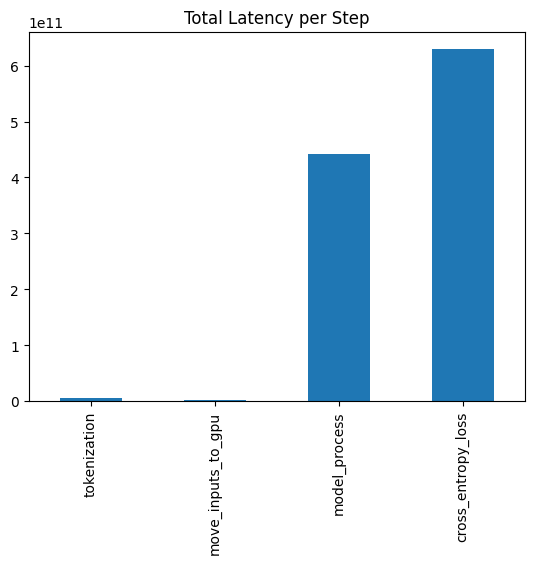

In [16]:
# latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', "end"])
# get_cel = get cross entropy loss
latency_df = pd.DataFrame(columns=['tokenization', 'move_inputs_to_gpu', 'model_process', 'cross_entropy_loss'])

latency_df["tokenization"] = latency["tokenize"] - latency["start"]
latency_df["move_inputs_to_gpu"] = latency["move_to_gpu"] - latency["tokenize"]
latency_df["model_process"] = latency["model"] - latency["move_to_gpu"]
latency_df["cross_entropy_loss"] = latency["end"] - latency["model"]

latency_sums = latency_df.sum()
# Create a bar plot
latency_sums.plot(kind='bar')

# Add title and labels
plt.title('Total Latency per Step')

# Display the plot
plt.show()

### Latency & GPU Usage vs Sequence Length

In [17]:
gpu_util_df.head()

,timestamp,tag,duration,nvidia_gpu_0
0,1.711772e+09,run,2.667817,239355
1,1.711772e+09,run,0.252906,29921
2,1.711772e+09,run,0.026477,3426
3,1.711772e+09,run,0.102412,10018
4,1.711772e+09,run,0.100840,6193


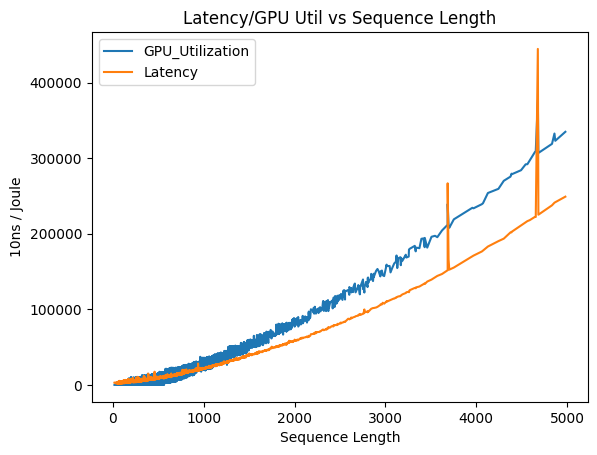

In [18]:
# Normalize Duration
duration = gpu_util_df["duration"] * 100000

lat_gpu_slen = {"Latency": duration, "GPU_Utilization": gpu_util_df["nvidia_gpu_0"], "Sequence_Length": sequence_length}
lat_gpu_slen_df = pd.DataFrame(lat_gpu_slen)
lat_gpu_slen_df = lat_gpu_slen_df.sort_values(by = 'Sequence_Length')

# Plot multiple lines
plt.plot(lat_gpu_slen_df["Sequence_Length"], lat_gpu_slen_df["GPU_Utilization"], label='GPU_Utilization')
plt.plot(lat_gpu_slen_df["Sequence_Length"], lat_gpu_slen_df["Latency"], label='Latency')

plt.xlabel('Sequence Length')
plt.ylabel('10ns / Joule')

plt.title("Latency/GPU Util vs Sequence Length")
plt.legend()

plt.show()